In [1]:
import sys
import os

In [2]:
sys.path.append("../")

In [3]:
from modelhub_client import ModelHub

model_config_urls = [
    # text localization
    "http://models.vsp.net.ua/config_model/craft-mlt/model-1.json",
    "http://models.vsp.net.ua/config_model/craft-refiner/model-1.json",
]

# initial
local_storage = os.environ.get('LOCAL_STORAGE', "../data")
modelhub = ModelHub(model_config_urls=model_config_urls,
                    local_storage=local_storage)


In [4]:
model_info = modelhub.download_model_by_name("craft_mlt")
mtl_model_path = model_info["path"]

model_info = modelhub.download_model_by_name("craft_refiner")
refiner_model_path = model_info["path"]

In [52]:
import sys
import os
import time
import argparse
import copy

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image

import matplotlib.pyplot as plt
import cv2
from skimage import io
import numpy as np
import craft_utils
import imgproc
import file_utils
import json
import zipfile

from craft import CRAFT
from refinenet import RefineNet
from collections import OrderedDict

In [6]:
def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")

In [39]:
def test_net(net, image, text_threshold, link_threshold, 
             low_text, cuda, poly, refine_net=None, is_det_char_boxes=True):
    t0 = time.time()

    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()

    t0 = time.time() - t0
    t1 = time.time()

    # Post-processing
    char_boxes = None
    if is_det_char_boxes:
        boxes, polys, char_boxes = craft_utils.getWordAndCharBoxes(image, score_text, score_link, text_threshold, 
                                                                   link_threshold, low_text, poly)
    else:
        boxes, polys  = craft_utils.getDetBoxes(score_text, score_link, text_threshold, 
                                                link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    char_boxes = craft_utils.adjustResultCoordinates(char_boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]

    t1 = time.time() - t1

    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)

    return char_boxes, boxes, polys, ret_score_text

In [40]:
cuda = False
refine = True
text_threshold = 0.6
link_threshold = 0.7
low_text = 0.4
canvas_size = 300
mag_ratio = 1.0

In [41]:
net = CRAFT()     # initialize

In [42]:
if cuda:
    net.load_state_dict(copyStateDict(torch.load(mtl_model_path)))
else:
    net.load_state_dict(copyStateDict(torch.load(mtl_model_path, map_location='cpu')))

In [43]:
if cuda:
    net = net.cuda()
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = False

net.eval()

CRAFT(
  (basenet): vgg16_bn(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (slice2): Sequential(
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kerne

In [44]:
# LinkRefiner
refine_net = None
if refine:
    refine_net = RefineNet()
    if cuda:
        refine_net.load_state_dict(copyStateDict(torch.load(refiner_model_path)))
        refine_net = refine_net.cuda()
        refine_net = torch.nn.DataParallel(refine_net)
    else:
        refine_net.load_state_dict(copyStateDict(torch.load(refiner_model_path, map_location='cpu')))

    refine_net.eval()
    poly = True

In [45]:
image_list, _, _ = file_utils.get_files("../data/cropped_images")
result_folder = "../data/result_images"

polys (14, 2)
polys (4, 2)
elapsed time : 0.26813483238220215s


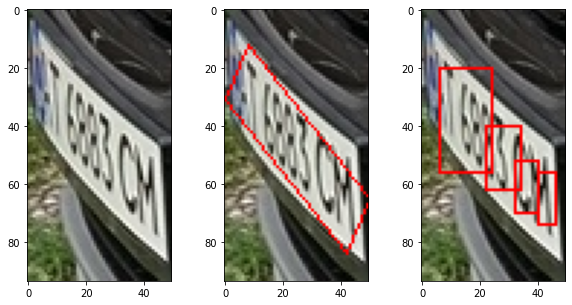

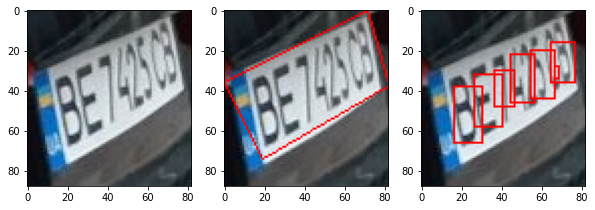

In [91]:
t = time.time()

# load data
for k, image_path in enumerate(image_list):
    image = imgproc.loadImage(image_path)

    char_boxes, bboxes, polys, score_text = test_net(net, image, 
                                                     text_threshold, 
                                                     link_threshold, 
                                                     low_text, 
                                                     cuda, 
                                                     poly, refine_net)
    
    bboxes_img = copy.deepcopy(image)
    for bbox in bboxes:
        pts = np.array(bbox, np.int32)
        pts = pts.reshape((-1, 1, 2))
        pts[pts<0] = 0
        pts[:,:,0][pts[:,:,0] > image.shape[1]] = image.shape[1]
        pts[:,:,1][pts[:,:,1] > image.shape[0]] = image.shape[0]
        bboxes_img = cv2.polylines(bboxes_img, 
                                   [pts], 
                                   isClosed=True,
                                   color=(255, 0, 0), 
                                   thickness=1)
    
    char_bboxes_img = copy.deepcopy(image)
    for bbox in char_boxes:
        pts = np.array(bbox, np.int32)
        pts = pts.reshape((-1, 1, 2))
        pts[pts<0] = 0
        pts[:,:,0][pts[:,:,0] > image.shape[1]] = image.shape[1]
        pts[:,:,1][pts[:,:,1] > image.shape[0]] = image.shape[0]
        char_bboxes_img = cv2.polylines(char_bboxes_img, 
                                   [pts], 
                                   isClosed=True,
                                   color=(255, 0, 0), 
                                   thickness=1)
        
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(image)
    ax[1].imshow(bboxes_img)
    ax[2].imshow(char_bboxes_img)
    
    print("polys", polys[0].shape)
    polys[0][polys[0]<0] = 0
    polys[0][:,0][polys[0][:,0] > image.shape[1]] = image.shape[1]
    polys[0][:,1][polys[0][:,1] > image.shape[0]] = image.shape[0]

    # save score text
    filename, file_ext = os.path.splitext(os.path.basename(image_path))
    mask_file = result_folder + "/res_" + filename + '_mask.jpg'
    cv2.imwrite(mask_file, score_text)

    file_utils.saveResult(image_path, image[:,:,::-1], 
                          polys, dirname=result_folder)

print("elapsed time : {}s".format(time.time() - t))